In [1]:
from image_loader import ImageLoader

import logging
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import scipy
from tqdm import tqdm

In [2]:
iml_large = ImageLoader(
    datapath=Path(
        ".",
        "..",
        "data",
        "raw"
    ),
    exposure_time_ms=9.0,
    pattern="rb3.2_*_*_*.png",
    log_level=logging.INFO
)

RESULTS_PATH = Path(".", "..", "data", "results")

INFO:image_loader:Initialized ImageLoader in path: ../data/raw
INFO:image_loader:	Parameters: exposure_time_ms = 9.0, pattern = rb3.2_*_*_*.png
INFO:image_loader:self.dirfiles size = 3000


In [3]:
TEXPS = np.arange(2.0, 9.1, 0.5)
RB_CURRENTS = np.array([3.2])

TARGET_INDICES = np.array(
    [
        22,
        23,
        24,
        25,
        26,
        27,
        32,
        33,
        36,
        37,
        38,
        39,
        40,
        43,
        44,
        45,
        46,
        47,
        48,
        49,
        52,
        53,
        54,
        55,
        56,
        59,
        60,
        61,
        62,
        63,
        64,
        65,
        68,
        69,
        70,
        71,
        72,
        75,
        76,
        81,
        82,
        83,
        84,
        85,
        86,
    ]
)
# 20 perepherial + 25 center = 45
assert TARGET_INDICES.shape[0] == 45, "Wrong traps alignment"
TARGET_INDICES

array([22, 23, 24, 25, 26, 27, 32, 33, 36, 37, 38, 39, 40, 43, 44, 45, 46,
       47, 48, 49, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 64, 65, 68, 69,
       70, 71, 72, 75, 76, 81, 82, 83, 84, 85, 86])

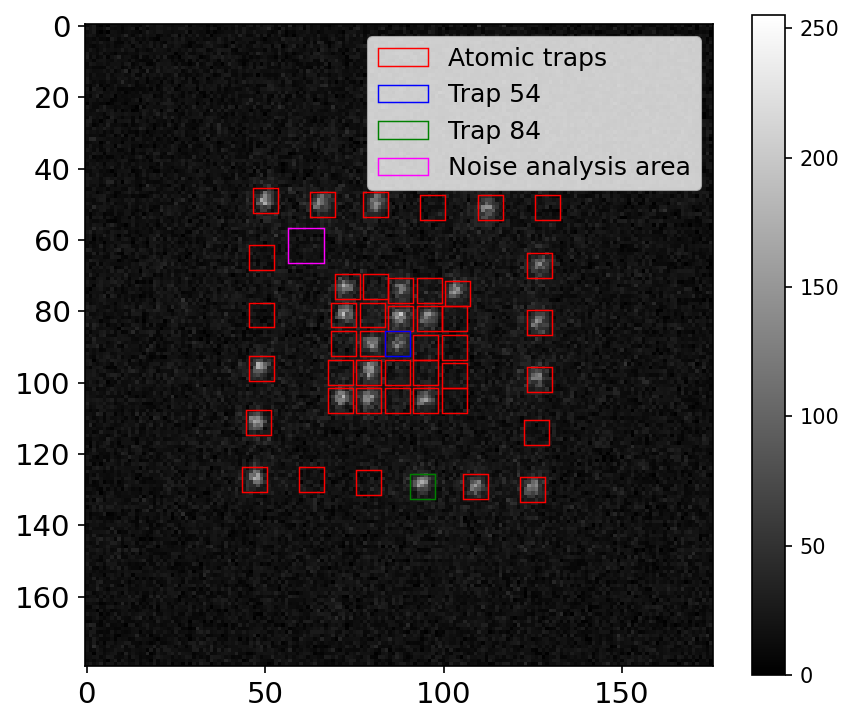

In [4]:
trap_radius = 3.5
SHOW_TRAPS = True

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)
plt.imshow(iml_large.first[100, ::, ::], cmap="grey", vmin=0, vmax=255)
if SHOW_TRAPS:
    for trap_ind in iml_large.trap_xy:
        if trap_ind not in [54, 84]:
            color = "red"
            label = "Atomic traps" if trap_ind == TARGET_INDICES[0] else ""
        elif trap_ind == 54:
            color = "blue"
            label = f"Trap {trap_ind}"
        elif trap_ind == 84:
            color = "green"
            label = f"Trap {trap_ind}"
        ax.add_patch(
            Rectangle(
                (
                    round(iml_large.trap_xy[trap_ind][0] - trap_radius) - 0.5,
                    round(iml_large.trap_xy[trap_ind][1] - trap_radius) - 0.5,
                ),
                trap_radius * 2,
                trap_radius * 2,
                fill=False,
                color=color,
                linewidth=0.7,
                label=label,
            )
        )
# Noise correlation analysis area
ax.add_patch(
    Rectangle(
        (
            57 - 0.5,
            57 - 0.5,
        ),
        10,
        10,
        fill=False,
        color="magenta",
        linewidth=0.7,
        label="Noise analysis area",
    )
)
plt.colorbar()
ax.tick_params(axis="both", which="major", labelsize=14)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.savefig(RESULTS_PATH / "trap_array_marked_traps_en.pdf", dpi=300, bbox_inches="tight")
plt.savefig(RESULTS_PATH / "trap_array_marked_traps_en.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
iml_large.data.shape

(3000, 180, 176)

Number of filled traps = 959


100%|██████████| 1155/1155 [00:03<00:00, 322.93it/s]


Trap radius 3B = 4.146
A = 92 \pm 11, B = 1.38 \pm 0.09, C = 35.42 \pm 0.67


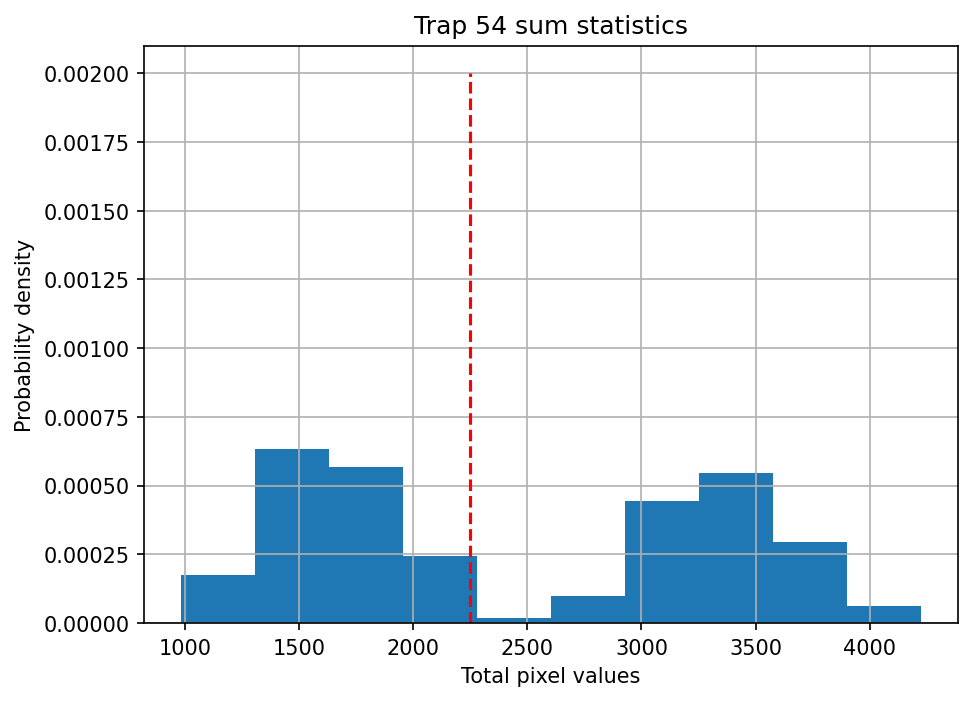

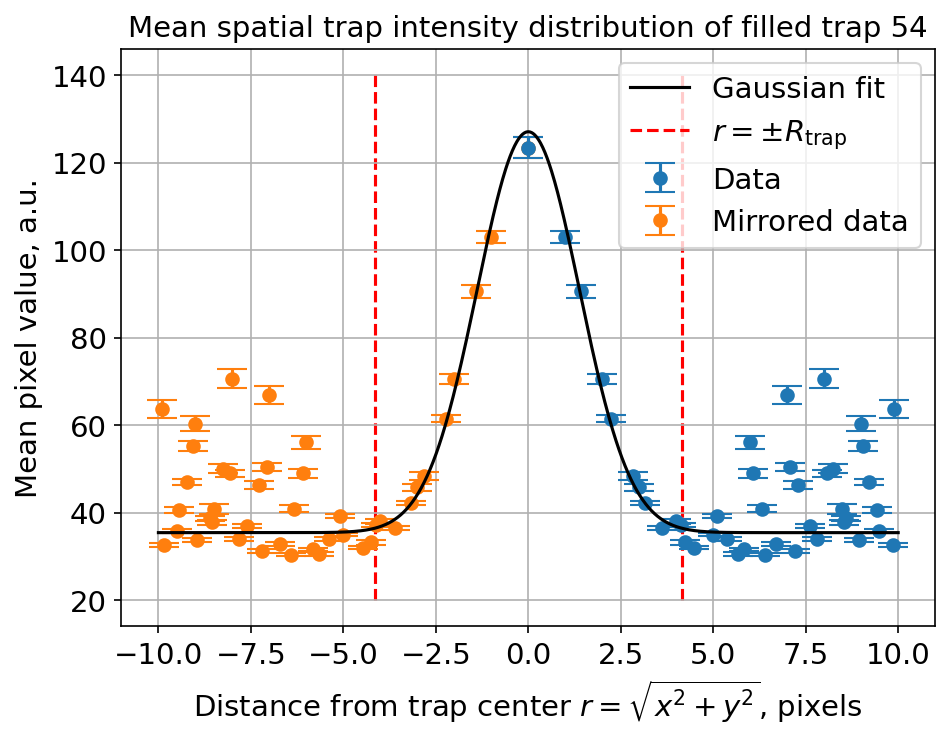

Number of filled traps = 817


100%|██████████| 2312/2312 [00:01<00:00, 1299.55it/s]


Trap radius 3B = 5.225
A = 98 \pm 4, B = 1.74 \pm 0.03, C = 19.71 \pm 0.15


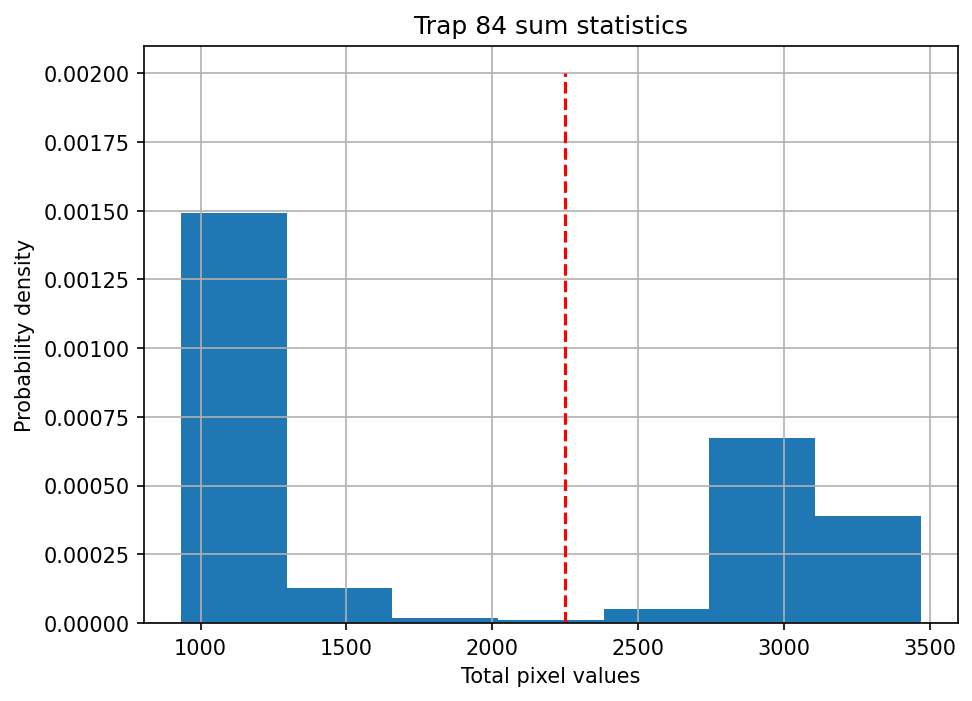

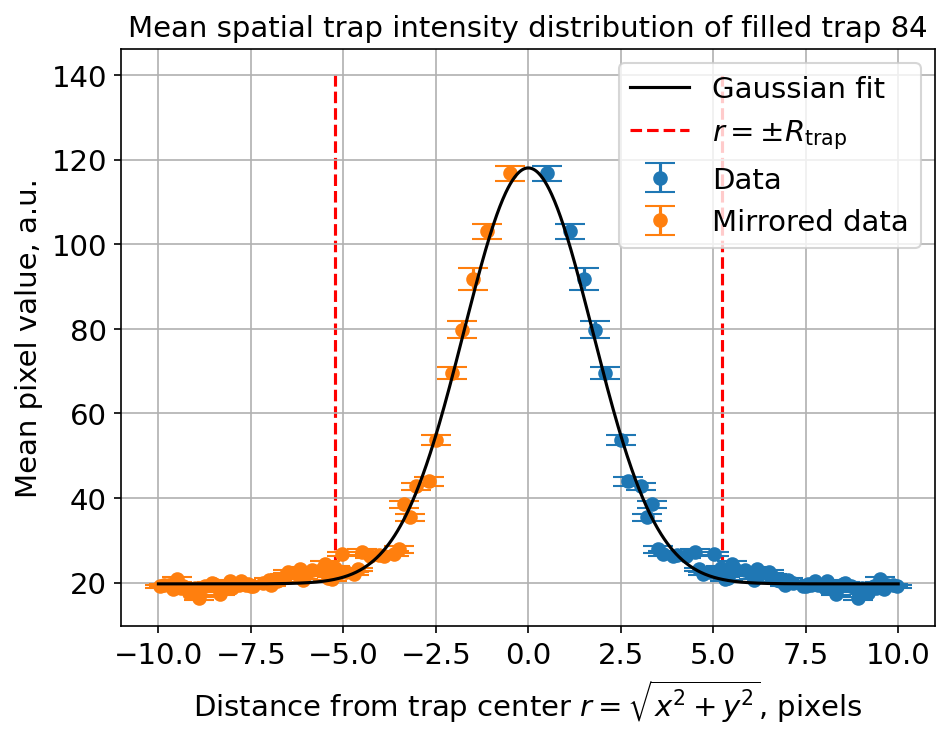

In [6]:
# Define trap
THRESHOLD = 2250
SHAPE = int(2 * trap_radius + (trap_radius % 2))
for INDEX in [[54], [84]]:
    iml_large.update_mask(trap_inds=INDEX, trap_radius=trap_radius)
    dat = iml_large.remasked_data_first.sum(axis=(1, 2)).data
    h = scipy.stats.iqr(dat) * 2 * dat.shape[0] ** (-1 / 3)

    # Plot trap pixels sum histogram to ensure threshold
    fig, ax = plt.subplots(1, 1, dpi=150, figsize=(7, 5))
    ax.hist(
        dat,
        bins=round((dat.max() - dat.min()) / h),
        density=True,
        label="Data",
    )
    ax.vlines(THRESHOLD, 0, 2e-3, color="red", linestyles="dashed")
    ax.set_title(f"Trap {INDEX[0]} sum statistics")
    ax.set_xlabel("Total pixel values")
    ax.set_ylabel("Probability density")
    ax.grid()

    # Retrieve data
    from itertools import product

    data_r = []
    data_val = []
    data_err = []
    data_dict = {}
    center_x, center_y = iml_large.trap_xy[INDEX[0]][0], iml_large.trap_xy[INDEX[0]][1]
    x_ind = np.arange(
        np.round(center_x - 2 * SHAPE), np.round(center_x + 2 * SHAPE + 1)
    ).astype(int)
    y_ind = np.arange(
        np.round(center_x - 2 * SHAPE), np.round(center_y + 2 * SHAPE + 1)
    ).astype(int)

    ddat = np.concat(
        (
            iml_large.first[
                (iml_large.remasked_data_first.sum(axis=(1, 2)).data >= THRESHOLD)
            ],
            iml_large.third[
                (iml_large.remasked_data_third.sum(axis=(1, 2)).data >= THRESHOLD)
            ],
        ),
        axis=0,
    )
    print(f"Number of filled traps = {ddat.shape[0]}")
    for x, y in tqdm(product(x_ind, y_ind), total=x_ind.shape[0] * y_ind.shape[0]):
        r = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
        if r < 10:
            for i in np.arange(ddat.shape[0]):
                val = ddat[i, y, x]
                data_dict[r] = data_dict.get(r, []) + [val]
                if r > 0:
                    data_dict[-r] = data_dict.get(-r, []) + [val]

    # Define fitting curve and collect data as np.ndarray
    from scipy.optimize import curve_fit

    def Gauss(x, A, B, C):
        y = A * np.exp(-(x**2) / 2 / B**2) + C
        return y

    xdata = []
    ydata = []
    errdata = []
    for key, val in data_dict.items():
        xdata.append(key)
        ydata.append(np.mean(np.array(val)))
        errdata.append(np.std(np.array(val), ddof=1) / np.sqrt(len(val)))
    xdata, ydata, errdata = map(np.array, (xdata, ydata, errdata))

    # Fit data
    parameters, covariance = curve_fit(
        Gauss,
        xdata,
        ydata,
        sigma=errdata,
        bounds=([-np.inf, 0, -np.inf], np.inf),
        p0=(1000, 1.7, 20),
    )

    fit_A = parameters[0]
    fit_B = parameters[1]
    fit_C = parameters[2]
    # print(f"{fit_A:.3f}, {fit_B:.3f}, {fit_C:.3f}")
    # print(f"Parameter errors = {np.sqrt(np.diag(covariance))}")
    print(f"Trap radius 3B = {3 * fit_B:.3f}")
    print(
        f"A = {fit_A:.0f} \pm {np.sqrt(np.diag(covariance))[0]:.0f}, B = {fit_B:.2f} \pm {np.sqrt(np.diag(covariance))[1]:.2f}, C = {fit_C:.2f} \pm {np.sqrt(np.diag(covariance))[2]:.2f}"
    )

    fit_y = Gauss(np.linspace(-10, 10, 1000), fit_A, fit_B, fit_C)

    # Plot
    fig = plt.figure(figsize=(7, 5), dpi=150)
    plt.errorbar(
        xdata[xdata >= 0],
        ydata[xdata >= 0],
        yerr=errdata[xdata >= 0] * 2.576,
        fmt="o",
        label="Data",
        zorder=5,
        capsize=7,
    )
    plt.errorbar(
        -xdata[xdata >= 0],
        ydata[xdata >= 0],
        yerr=errdata[xdata >= 0] * 2.576,
        fmt="o",
        label="Mirrored data",
        zorder=4,
        capsize=7,
    )
    plt.plot(
        np.linspace(-10, 10, 1000),
        fit_y,
        label="Gaussian fit",
        color="black",
        zorder=10,
    )
    plt.vlines(
        [-3 * fit_B, 3 * fit_B],
        20,
        140,
        linestyles="dashed",
        color="red",
        label=r"$r = \pm R_\mathrm{trap}$",
        zorder=-5,
    )

    plt.xlabel(
        "Distance from trap center " + "$r = \sqrt{x^2 + y^2}$, pixels", fontsize=14
    )
    plt.ylabel("Mean pixel value, a.u.", fontsize=14)
    plt.gca().tick_params(axis="both", which="major", labelsize=14)
    plt.legend(loc="upper right", fontsize=14)
    plt.grid()
    plt.savefig(
        RESULTS_PATH / f"gaussian_spatial_intensity_trap_{INDEX[0]}_en.pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        RESULTS_PATH / f"gaussian_spatial_intensity_trap_{INDEX[0]}_en.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.title(
        f"Mean spatial trap intensity distribution of filled trap {INDEX[0]}",
        fontsize=14,
    )
    plt.show()

# Noise correlation radius

In [7]:
data_for_noise_analysis = np.concat(
    (
        iml_large.first,
        iml_large.third,
    ),
    axis=0,
)
data_for_noise_analysis.shape

(2000, 180, 176)

In [8]:
np.corrcoef(data_for_noise_analysis[::, 4, 4], data_for_noise_analysis[::, 4, 5])

array([[1.        , 0.01798704],
       [0.01798704, 1.        ]])

In [9]:
rs = []
corrs = []
data_for_noise_analysis = iml_large.data[::, 57:67, 57:67] # see above for area
size = 10
for i in range(size):
    for j in range(size):
        for ii in range(size):
            for jj in range(size):
                r = np.sqrt((i - ii) ** 2 + (j - jj) ** 2)
                rs.append(r)

                corr = np.corrcoef(
                    data_for_noise_analysis[::, ii, jj],
                    data_for_noise_analysis[::, i, j],
                )
                corrs.append(corr[0, 1])

In [10]:
# process rs and corrs
rs_to_corrs = dict()
for r, corr in zip(rs, corrs):
    if r in rs_to_corrs:
        rs_to_corrs[r] += [corr]
    else:
        rs_to_corrs[r] = [corr]

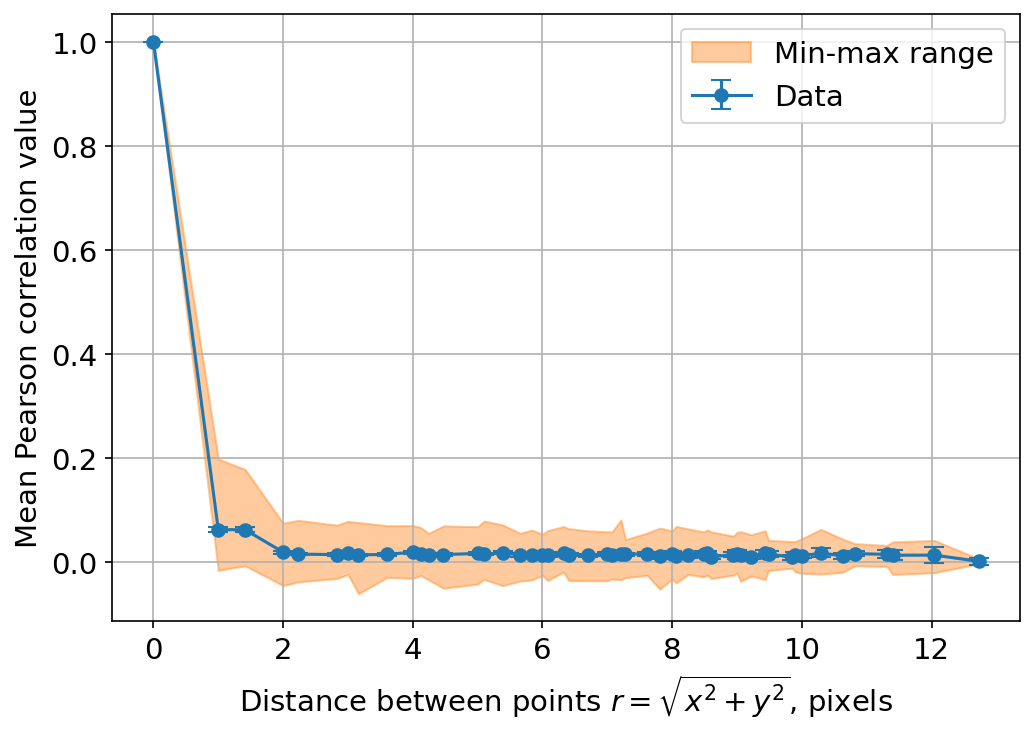

In [11]:
corr_data = list(sorted([(x, y) for x, y in rs_to_corrs.items()], key=lambda x: x[0]))

fig = plt.figure(figsize=(7, 5), dpi=150)
plt.errorbar(
    [pair[0] for pair in corr_data],
    [np.mean(pair[1]) for pair in corr_data],
    yerr=[np.std(pair[1]) / np.sqrt(len(pair[1])) * 2.576 for pair in corr_data],
    color="C0",
    fmt="-o",
    capsize=5,
    label="Data",
)
plt.fill_between(
    [pair[0] for pair in corr_data],
    [np.max(pair[1]) for pair in corr_data],
    [np.min(pair[1]) for pair in corr_data],
    alpha=0.4,
    color="C1",
    label="Min-max range",
)
plt.gca().tick_params(axis="both", which="major", labelsize=14)
plt.grid()
plt.xlabel("Distance between points " + "$r = \sqrt{x^2 + y^2}$, pixels", fontsize=14)
plt.ylabel("Mean Pearson correlation value", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.tight_layout()
plt.savefig(RESULTS_PATH / "corr_radius_en.pdf", dpi=300, bbox_inches="tight")
plt.savefig(RESULTS_PATH / "corr_radius_en.png", dpi=300, bbox_inches="tight")
plt.show()